# Data Setup

The first thing to do is implement a dataset class to load rotated CIFAR10 images with matching labels. Since there is already a CIFAR10 dataset class implemented in `torchvision`, we will extend this class and modify the `__get_item__` method appropriately to load rotated images.

Each rotation label should be an integer in the set {0, 1, 2, 3} which correspond to rotations of 0, 90, 180, or 270 degrees respectively.

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as tf
import numpy as np
import random


def rotate_img(img, rot):
    # print(img, img.shape)
    return tf.rotate(img, angle=rot * 90)  # rotate by 90 degrees for each step

    if rot == 0: # 0 degrees rotation
        return img
    else:
        return img
        # raise ValueError('rotation should be 0, 90, 180, or 270 degrees')


class CIFAR10Rotation(torchvision.datasets.CIFAR10):
    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = CIFAR10Rotation(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = CIFAR10Rotation(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified


/u/kramesh/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Files already downloaded and verified


Show some example images and rotated images with labels:

/u/kramesh/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..1.0].


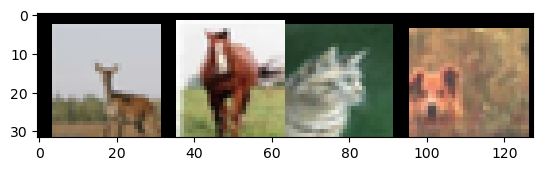

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..1.0].


Class labels:  deer  horse cat   dog  


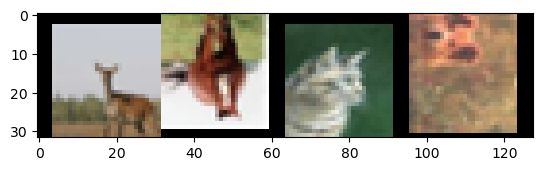

Rotation labels:  0     180   0     270  


In [4]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

# Evaluation code

In [5]:
import time

# evaluates the performance of your network.
def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)

            outputs = net(images)

            # predicted label is the one with the highest softmax score.
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # print(predicted, labels)

            # loss
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

In [6]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

## 1. Train a ResNet18 on the rotation task

In this section, we will train a ResNet18 model on the rotation task. The input is a rotated image and the model predicts the rotation label. See the Data Setup section for details.

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(num_classes=4)
net = net.to(device)

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# i could try out other optimizers like Adam, but SGD is a good start
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [ ]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)

            # TODO: Set the data to the correct device; Different task will use different inputs and labels
            #
            if task == 'rotation':
                images, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
                images, labels = imgs.to(device), cls_label.to(device)
            else:
                raise ValueError('task should be either "rotation" or "classification"')

            optimizer.zero_grad()

            outputs = net(images)

            outputs = outputs.to(device)

            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()
            
            predicted = torch.max(outputs.data, 1)[1]

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()


        net.eval()  # set the model to evaluation mode
        if task == 'rotation':
            print("Testing on rotation task...")
            run_test(net, testloader, criterion, task='rotation')
        elif task == 'classification':
            print("Testing on classification task...")
            run_test(net, testloader, criterion, task='classification')
        else:
            raise ValueError('task should be either "rotation" or "classification"')
        print(f'Finished epoch {epoch + 1} / {num_epochs}')
        print('-----------------------------------')
        

    print('Finished Training')

In [11]:
train(net, criterion, optimizer, num_epochs=45, decay_epochs=15, init_lr=0.01, task='rotation')

PATH = './rotation_net.pth'
torch.save(net.state_dict(), PATH)
print(f'Model saved to {PATH}')


[1,   100] loss: 1.357 acc: 38.84 time: 9.85
[1,   200] loss: 1.179 acc: 48.26 time: 6.06
[1,   300] loss: 1.150 acc: 49.66 time: 6.05
Testing on rotation task...
TESTING:
Accuracy of the network on the 10000 test images: 55.09 %
Average loss on the 10000 test images: 1.049
Finished epoch 1 / 45
-----------------------------------
[2,   100] loss: 1.090 acc: 53.18 time: 7.58
[2,   200] loss: 1.073 acc: 53.95 time: 6.13
[2,   300] loss: 1.053 acc: 54.91 time: 6.02
Testing on rotation task...
TESTING:
Accuracy of the network on the 10000 test images: 57.88 %
Average loss on the 10000 test images: 1.005
Finished epoch 2 / 45
-----------------------------------
[3,   100] loss: 1.024 acc: 56.34 time: 7.59
[3,   200] loss: 1.007 acc: 57.47 time: 6.04
[3,   300] loss: 1.016 acc: 57.23 time: 6.04
Testing on rotation task...
TESTING:
Accuracy of the network on the 10000 test images: 59.97 %
Average loss on the 10000 test images: 0.952
Finished epoch 3 / 45
-----------------------------------
[

## 2.1 Fine-tuning on the pre-trained model

In this section, we will load the pre-trained ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

PATH = './rotation_net.pth'
net = resnet18(num_classes=4)  # we are doing 4-class classification
print(PATH)
net.load_state_dict(torch.load(PATH, weights_only=True, map_location=device))  # load the saved weights
net = net.to(device)


./rotation_net.pth


In [ ]:
# print device of pretrained_net
print("Pretrained network device:", next(net.parameters()).device)


Pretrained network device: cuda:0


In [ ]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
for name, param in net.named_parameters():
    if name.startswith('layer4') or name.startswith('fc'):
        param.requires_grad = True
    else:
        param.requires_grad = False

# update the fc layer to have 10 classes
num_classes = 10
net.fc = nn.Linear(net.fc.in_features, num_classes, device=device)

In [ ]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name, param.device)

Params to learn:
	 layer4.0.conv1.weight cuda:0
	 layer4.0.bn1.weight cuda:0
	 layer4.0.bn1.bias cuda:0
	 layer4.0.conv2.weight cuda:0
	 layer4.0.bn2.weight cuda:0
	 layer4.0.bn2.bias cuda:0
	 layer4.0.downsample.0.weight cuda:0
	 layer4.0.downsample.1.weight cuda:0
	 layer4.0.downsample.1.bias cuda:0
	 layer4.1.conv1.weight cuda:0
	 layer4.1.bn1.weight cuda:0
	 layer4.1.bn1.bias cuda:0
	 layer4.1.conv2.weight cuda:0
	 layer4.1.bn2.weight cuda:0
	 layer4.1.bn2.bias cuda:0
	 fc.weight cuda:0
	 fc.bias cuda:0


In [16]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params_to_update, lr=0.01, momentum=0.9)

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

# save the fine-tuned model
PATH = './fine_tuned_pre_trained_net.pth'
torch.save(net.state_dict(), PATH)
print(f'Fine-tuned model saved to {PATH}')

[1,   100] loss: 1.691 acc: 38.64 time: 7.38
[1,   200] loss: 1.441 acc: 47.86 time: 5.84
[1,   300] loss: 1.390 acc: 49.61 time: 5.87
Testing on classification task...
TESTING:
Accuracy of the network on the 10000 test images: 53.29 %
Average loss on the 10000 test images: 1.288
Finished epoch 1 / 20
-----------------------------------
[2,   100] loss: 1.325 acc: 51.59 time: 7.42
[2,   200] loss: 1.309 acc: 53.34 time: 5.82
[2,   300] loss: 1.301 acc: 52.80 time: 5.83
Testing on classification task...
TESTING:
Accuracy of the network on the 10000 test images: 56.47 %
Average loss on the 10000 test images: 1.214
Finished epoch 2 / 20
-----------------------------------
[3,   100] loss: 1.259 acc: 55.26 time: 7.42
[3,   200] loss: 1.255 acc: 55.34 time: 5.88
[3,   300] loss: 1.259 acc: 54.41 time: 5.82
Testing on classification task...
TESTING:
Accuracy of the network on the 10000 test images: 57.52 %
Average loss on the 10000 test images: 1.192
Finished epoch 3 / 20
-------------------

## 2.2 Fine-tuning on the randomly initialized model
In this section, we will randomly initialize a ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [18]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
#
#
#

net = resnet18(num_classes=num_classes)  # we are doing 10-class classification
net = net.to(device)


In [19]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
# To do this, you should set requires_grad=False for the frozen layers.
#
#
#

for name, param in net.named_parameters():
    if name.startswith('layer4') or name.startswith('fc'):
        param.requires_grad = True
    else:
        param.requires_grad = False

In [20]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [21]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params_to_update, lr=0.01, momentum=0.9)

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

PATH = './fine_tuned_random_net.pth'
torch.save(net.state_dict(), PATH)
print(f'Fine-tuned model saved to {PATH}')

[1,   100] loss: 2.138 acc: 23.96 time: 7.37
[1,   200] loss: 1.967 acc: 28.77 time: 5.73
[1,   300] loss: 1.924 acc: 30.72 time: 5.75
Testing on classification task...
TESTING:
Accuracy of the network on the 10000 test images: 29.74 %
Average loss on the 10000 test images: 1.946
Finished epoch 1 / 20
-----------------------------------
[2,   100] loss: 1.894 acc: 31.46 time: 7.53
[2,   200] loss: 1.864 acc: 32.69 time: 5.81
[2,   300] loss: 1.849 acc: 33.62 time: 5.81
Testing on classification task...
TESTING:
Accuracy of the network on the 10000 test images: 36.95 %
Average loss on the 10000 test images: 1.735
Finished epoch 2 / 20
-----------------------------------
[3,   100] loss: 1.805 acc: 34.88 time: 7.44
[3,   200] loss: 1.793 acc: 35.30 time: 5.82
[3,   300] loss: 1.815 acc: 34.63 time: 5.83
Testing on classification task...
TESTING:
Accuracy of the network on the 10000 test images: 38.98 %
Average loss on the 10000 test images: 1.694
Finished epoch 3 / 20
-------------------

## 3.1 Supervised training on the pre-trained model
In this section, we will load the pre-trained ResNet18 model and re-train the whole model on the classification task.

In [36]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Load the pre-trained ResNet18 model
#
#
#

net = resnet18(num_classes=4)
net.load_state_dict(torch.load(PATH, weights_only=True, map_location=device))  # load the saved weights
net = net.to(device)

net.fc = nn.Linear(net.fc.in_features, num_classes, device=device)  # update the fc layer to have 10 classes

In [37]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

PATH = './full_pre_trained_net.pth'
torch.save(net.state_dict(), PATH)
print(f'Fine-tuned model saved to {PATH}')

torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])


KeyboardInterrupt: 

## 3.2 Supervised training on the randomly initialized model
In this section, we will randomly initialize a ResNet18 model and re-train the whole model on the classification task.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(num_classes=num_classes)
net = net.to(device)

In [ ]:
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name, param.device)

In [39]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])


In [ ]:
PATH = './full_random_net.pth'
torch.save(net.state_dict(), PATH)
print(f'Fine-tuned model saved to {PATH}')